In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import functional
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader,random_split
import numpy as np
import matplotlib.pyplot as plt

In [9]:
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device=torch.device('cuda')
else:
    print('CUDA is not available.  Training on CPU ...')
    device=torch.device('cpu')

CUDA is available!  Training on GPU ...


In [10]:
num_workers = 0
batch_size = 20
valid_size = 0.2
transform = transforms.Compose([transforms.Resize(227),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


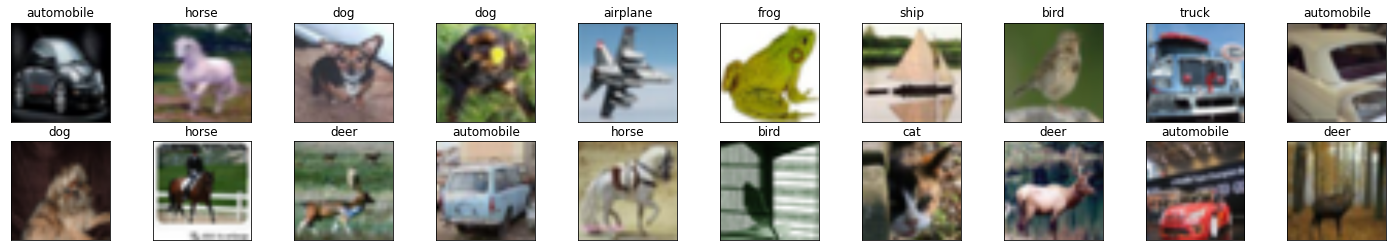

In [11]:
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [12]:
class alex_net(nn.Module):
    def __init__(self):
        super(alex_net,self).__init__()
        self.C1=nn.Conv2d(3,96,kernel_size=(11,11),stride=4)
        self.pool=nn.MaxPool2d(3,2)
        self.C2=nn.Conv2d(96,256,kernel_size=(5,5),padding=2)
        self.C3=nn.Conv2d(256,384,kernel_size=(3,3),padding=1)
        self.C4=nn.Conv2d(384,384,kernel_size=(3,3),padding=1)
        self.C5=nn.Conv2d(384,256,kernel_size=(3,3),padding=1)
        self.fc1=nn.Linear(9216,1024)
        self.fc2=nn.Linear(1024,128)
        self.fc3=nn.Linear(128,10)
        self.drop=nn.Dropout(0.5)
    def forward(self,x):
        x=self.pool(F.relu(self.C1(x)))
        x=self.pool(F.relu(self.C2(x)))
        x=F.relu(self.C3(x))
        x=F.relu(self.C4(x))
        x=self.pool(F.relu(self.C5(x)))
        x=x.view(x.shape[0],-1)
        x=self.drop(F.relu(self.fc1(x)))
        x=self.drop(F.relu(self.fc2(x)))
        x=self.fc3(x)
        return x
model=alex_net()
model=model.to(device)
print(model)

alex_net(
  (C1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)


In [13]:
optimizer=optim.Adam(model.parameters(),lr=0.01)
criterion=nn.CrossEntropyLoss()

In [14]:
from tqdm.notebook import tqdm
n_epochs = 10

valid_loss_min = np.Inf 
last_loss=None
train_losses, val_losses = [], []
for epoch in tqdm(range(1, n_epochs+1)):

    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 122.316331 	Validation Loss: 0.461048
Validation loss decreased (inf --> 0.461048).  Saving model ...
Epoch: 2 	Training Loss: 1.843712 	Validation Loss: 0.460739
Validation loss decreased (0.461048 --> 0.460739).  Saving model ...
Epoch: 3 	Training Loss: 1.843755 	Validation Loss: 0.461122
Epoch: 4 	Training Loss: 1.843585 	Validation Loss: 0.460654
Validation loss decreased (0.460739 --> 0.460654).  Saving model ...
Epoch: 5 	Training Loss: 1.843603 	Validation Loss: 0.461031
Epoch: 6 	Training Loss: 1.843599 	Validation Loss: 0.460751
Epoch: 7 	Training Loss: 1.843610 	Validation Loss: 0.461055
Epoch: 8 	Training Loss: 1.843532 	Validation Loss: 0.460746
Epoch: 9 	Training Loss: 1.843524 	Validation Loss: 0.460632
Validation loss decreased (0.460654 --> 0.460632).  Saving model ...
Epoch: 10 	Training Loss: 1.843676 	Validation Loss: 0.460645


In [15]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [21]:
train_on_gpu = torch.cuda.is_available()
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.303511

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile:  0% ( 0/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer: 100% (1000/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


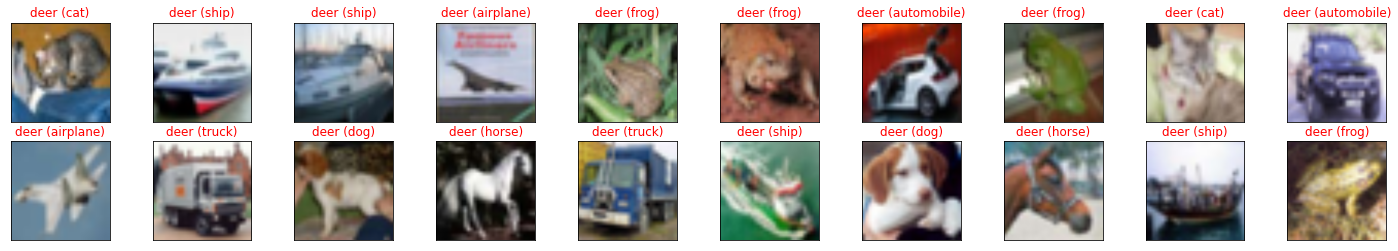

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

if train_on_gpu:
    images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))